In [1]:
# 训练深层神经网络十分困难，特别是在较短的时间内使它们收敛
# batch normalization可持续加速深层网络的收敛速度
# 再结合残差快，批量规范化使得研究人员能够训练100层以上的网络

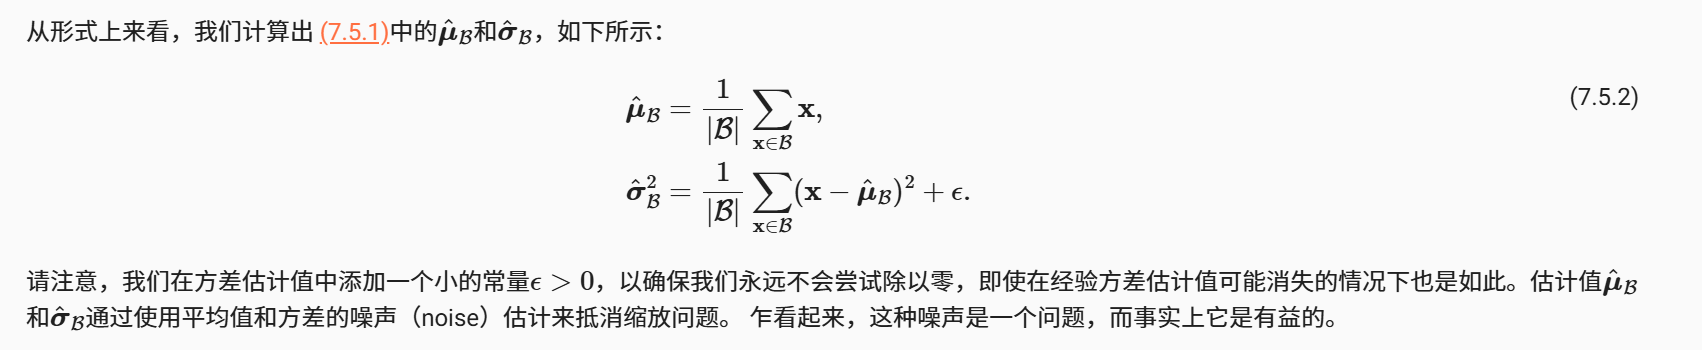

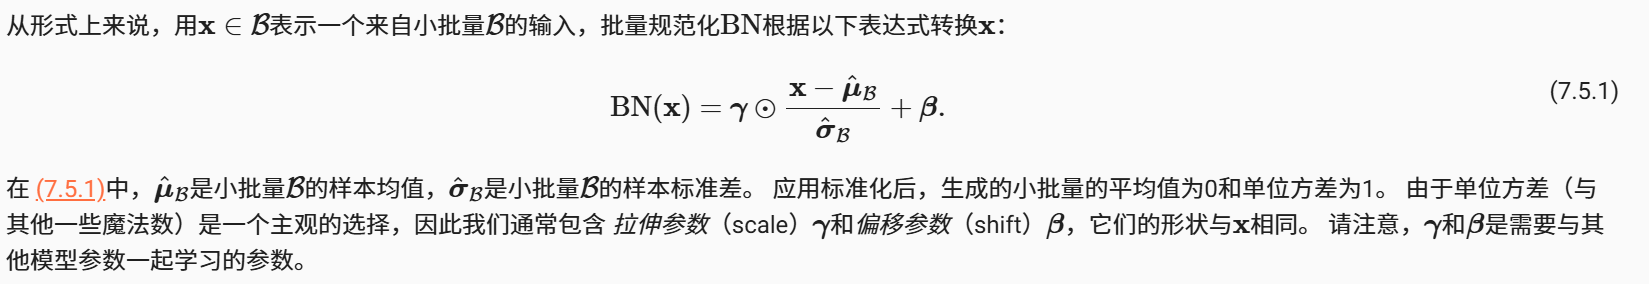

批量规范化层在”训练模式“（通过小批量统计数据规范化）和“预测模式”（通过数据集统计规范化）中的功能不同。 在训练过程中，我们无法得知使用整个数据集来估计平均值和方差，所以只能根据每个小批次的平均值和方差不断训练模型。 而在预测模式下，可以根据整个数据集精确计算批量规范化所需的平均值和方差。

In [2]:
# 全连接层
# 通常，将batch-norm层置于全连接层中的仿射变换和激活函数之间

# 卷积层
# 在卷积层之后和激活函数之前应用batch normalization
# 当卷积有多个输出通道时，我们需要对这些通道的“每个”输出执行batch normalization，每个通道都有自己的拉伸和偏移参数，这两个参数都是标量

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维（axis=1）的均值和方差
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data



In [5]:
# 现在可以创建一个正确的BatchNorm层，这个层将保持适当的参数：拉伸gamma和偏移beta，这两个参数将在训练过程中更新
# 此外，我们的层将保存均值和方差的移动平均值，以便在模型预测期间随后使用

# 层的基础设计模型
# 通常，我们用一个单独的函数定义其数学原理，比如说batch_norm
# 然后将此功能集成到一个自定义层中，其代码主要处理:
# 数据移动到训练设备（如GPU）、分配和初始化任何必须的变量、跟踪移动平均线（此处为均值和方差）等


In [6]:
class BatchNorm(nn.Module):
    # num_features: 全连接层的输出数量或者卷积层的输出通道数
    # num_dims：2表示全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9
        )
        return Y



In [7]:
# 使用批量规范化层的LeNet
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.260, train acc 0.904, test acc 0.853
38829.9 examples/sec on cuda:0


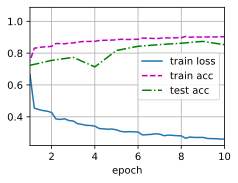

In [9]:
# 这次我们用大得多的学习率
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [10]:
# torch.cuda.empty_cache()
# torch.cuda.reset_peak_memory_stats()  # 重置显存统计信息

In [18]:
# 查看从第一个批量规范化层中学到的拉伸参数gamma和偏移参数beta
net[1].gamma, net[1].gamma.reshape(-1, ), net[1].beta.reshape(-1, )

(Parameter containing:
 tensor([[[[2.9711]],
 
          [[2.4104]],
 
          [[3.7103]],
 
          [[3.0201]],
 
          [[2.2625]],
 
          [[1.2073]]]], device='cuda:0', requires_grad=True),
 tensor([2.9711, 2.4104, 3.7103, 3.0201, 2.2625, 1.2073], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([ 3.2120,  2.9257, -2.2292,  1.6081, -2.4260,  1.3162], device='cuda:0',
        grad_fn=<ViewBackward0>))

In [19]:
# 简明实现
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.264, train acc 0.903, test acc 0.782
49539.8 examples/sec on cuda:0


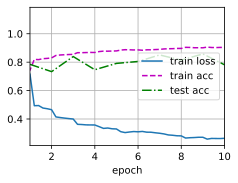

In [20]:
# 我们用相同的参数训练模型
# 注意：通常高级API变体运行速度快得多，因为它的代码已编译为C++或CUDA，而我们的自定义代码由Python实现
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())